### Importing all the libraries and data files

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# defininh the paths
path = 'C:\\Users\\Sanket Takle\\Documents\\0. House price prediction\\0. Data set'
os.chdir(path)

In [3]:
# Reading the data
Mumbai_base = pd.read_csv("Mumbai.csv")

## EDA and Data Pre-processing

In [4]:
# checking the percentage of missing values
features_with_na=[features for features in Mumbai_base.columns if Mumbai_base[features].isnull().sum()>1]
for feature in features_with_na:
    print(Mumbai_base, np.round(Mumbai_base[feature].isnull().mean(), 4),  ' % missing values')

As no output was given, the data contains no missing values

In [5]:
#adding  new columns and renaming few columns
Mumbai_base['PriceCr'] = Mumbai_base['Price']/10000000
Mumbai_base['PricePSF'] = Mumbai_base['Price'] / Mumbai_base['Area']
Mumbai_base.rename(columns={"Children'splayarea":'PlayArea'}, inplace=True)

In [6]:
# checking the datatype
Mumbai_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7719 entries, 0 to 7718
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                7719 non-null   int64  
 1   Area                 7719 non-null   int64  
 2   Location             7719 non-null   object 
 3   No. of Bedrooms      7719 non-null   int64  
 4   Resale               7719 non-null   int64  
 5   MaintenanceStaff     7719 non-null   int64  
 6   Gymnasium            7719 non-null   int64  
 7   SwimmingPool         7719 non-null   int64  
 8   LandscapedGardens    7719 non-null   int64  
 9   JoggingTrack         7719 non-null   int64  
 10  RainWaterHarvesting  7719 non-null   int64  
 11  IndoorGames          7719 non-null   int64  
 12  ShoppingMall         7719 non-null   int64  
 13  Intercom             7719 non-null   int64  
 14  SportsFacility       7719 non-null   int64  
 15  ATM                  7719 non-null   i

In [7]:
# replacing the unknown with null and dropping the null values
Mumbai_base.replace(9, np.nan, inplace=True)
Mumbai_base.dropna(inplace=True)

The data did not contain null values but had some unknow values in the features which need to be replaced and dropped for uniformity and better results

In [8]:
Mumbai_base.shape

(1397, 42)

<Axes: xlabel='PricePSF', ylabel='Density'>

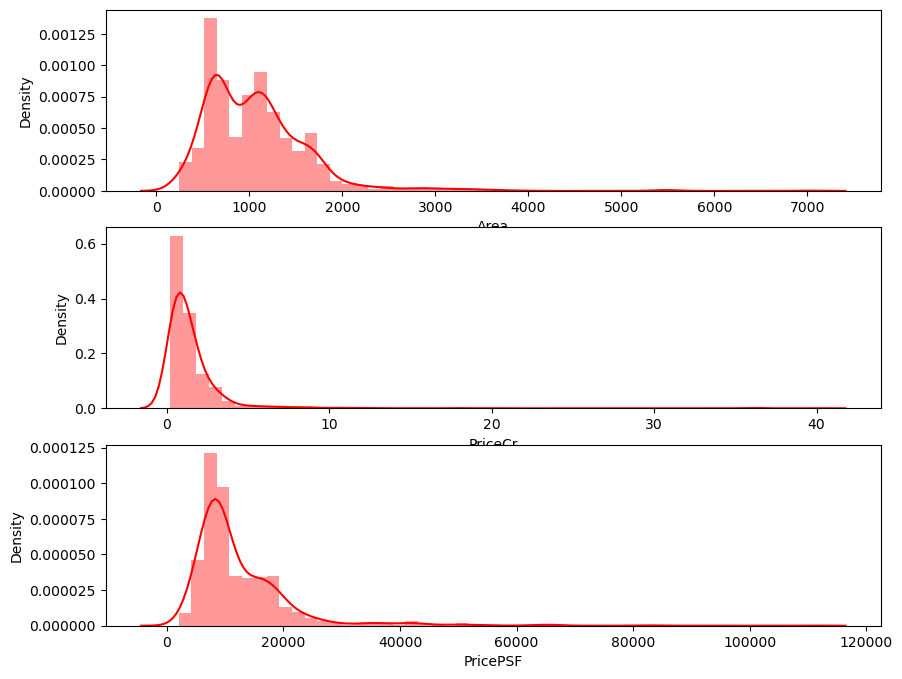

In [9]:
# check for skews by plotting the potential predictors
fig, axs = plt.subplots(nrows=3 , figsize=(10, 8))
sns.distplot(Mumbai_base['Area'], color='Red', ax=axs[0])
sns.distplot(Mumbai_base['PriceCr'], color='Red', ax=axs[1])
sns.distplot(Mumbai_base['PricePSF'], color='Red', ax=axs[2])

The above graphs indicats that the data is highly skewed and have outliers which needs to be rectified. 5% of the data from both the ends are dropped to get the majority of 90% data which will normalise it and rectify the skewness as much as possible

In [10]:
# Detecting the outliers
price_psf_outliers = np.percentile(Mumbai_base.PricePSF, [5,90])
price_outliers = np.percentile(Mumbai_base.Price, [5,90])
area_outliers = np.percentile(Mumbai_base.Area, [5,90])

# Removing the outliers
price_psf_filter = (Mumbai_base.PricePSF > price_psf_outliers[0]) & (Mumbai_base.PricePSF < price_psf_outliers[1])
price_filter = (Mumbai_base.Price > price_outliers[0]) & (Mumbai_base.Price < price_outliers[1])
area_filter = (Mumbai_base.Area > area_outliers[0]) & (Mumbai_base.Area < area_outliers[1])

# final Data without outliers
Mumbai_base = Mumbai_base[(price_psf_filter) & (price_filter) & (area_filter)]

<Axes: xlabel='PricePSF', ylabel='Density'>

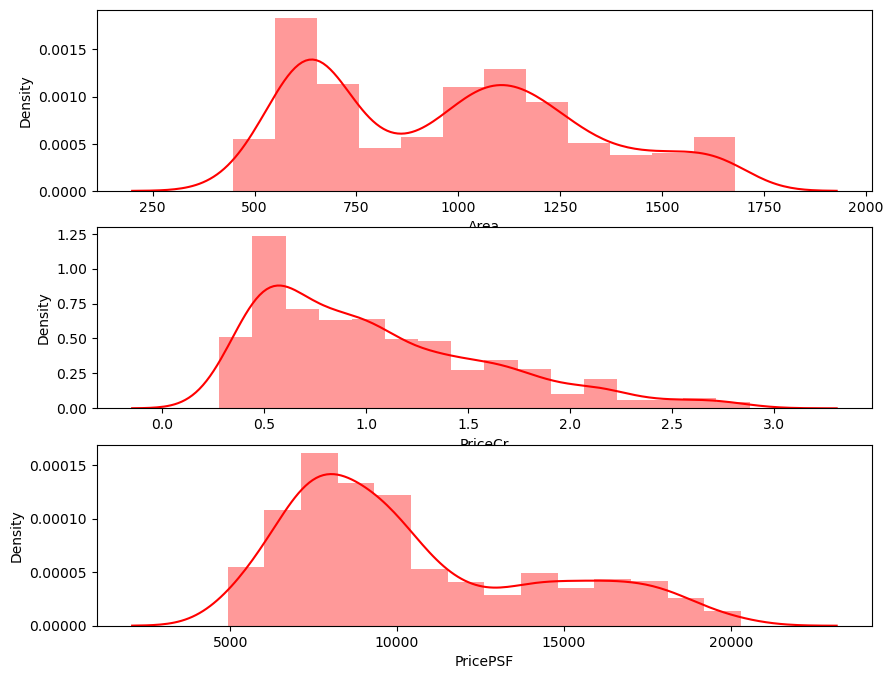

In [11]:
# Recheck after removing outliers by plotting the potential predictors
fig, axs = plt.subplots(nrows=3 , figsize=(10, 8))
sns.distplot(Mumbai_base['Area'], color='Red', ax=axs[0])
sns.distplot(Mumbai_base['PriceCr'], color='Red', ax=axs[1])
sns.distplot(Mumbai_base['PricePSF'], color='Red', ax=axs[2])

## Feature Selection and Feature Engineering

In [12]:
# assign weights to features
feature_dict = {'MaintenanceStaff':2, 'Gymnasium':4, 'SwimmingPool':4,'LandscapedGardens':3, 'JoggingTrack':3, 'RainWaterHarvesting':2,'IndoorGames':3, 'ShoppingMall':2, 'Intercom':2, 'SportsFacility':3, 'ATM':2, 'ClubHouse':2, 'School':2, '24X7Security':1, 'PowerBackup':4, 'CarParking':3, 'StaffQuarter':0, 'Cafeteria':0, 'MultipurposeRoom':2, 'Hospital':3, 'WashingMachine':0, 'Gasconnection':4, 'AC':0, 'Wifi':2, 'PlayArea':3, 'LiftAvailable':0, 'BED':0, 'VaastuCompliant':0, 'Microwave':0, 'GolfCourse':0, 'TV':0, 'DiningTable':0, 'Sofa':0, 'Wardrobe':0, 'Refrigerator':0}

features = pd.DataFrame(feature_dict.items(), columns=['Features', 'Weight'])

In [13]:
# Ceating an feature matrix
features_matrix = Mumbai_base[['MaintenanceStaff', 'Gymnasium', 'SwimmingPool',
       'LandscapedGardens', 'JoggingTrack', 'RainWaterHarvesting',
       'IndoorGames', 'ShoppingMall', 'Intercom', 'SportsFacility', 'ATM',
       'ClubHouse', 'School', '24X7Security', 'PowerBackup', 'CarParking',
       'StaffQuarter', 'Cafeteria', 'MultipurposeRoom', 'Hospital',
       'WashingMachine', 'Gasconnection', 'AC', 'Wifi', 'PlayArea',
       'LiftAvailable', 'BED', 'VaastuCompliant', 'Microwave',
       'GolfCourse', 'TV', 'DiningTable', 'Sofa', 'Wardrobe',
       'Refrigerator']]

In [14]:
# Creating a final feature score to represent all the additional columns
feature_scores_df = np.dot(features_matrix, features['Weight'])
Mumbai_base['FeatureScore'] = feature_scores_df

<Axes: >

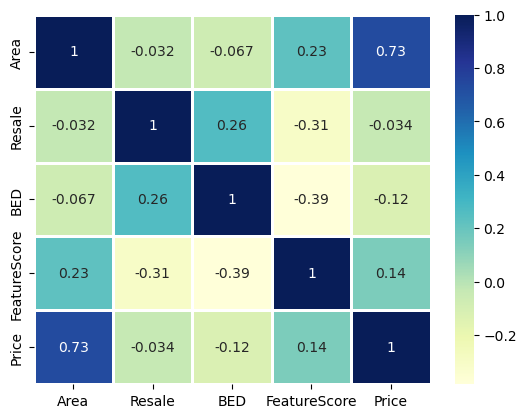

In [15]:
# checking corealtion betwen the remaing columns
corr_df = Mumbai_base[['Area', 'Resale', 'BED', 'FeatureScore', 'Price']]
sns.heatmap(corr_df.corr(method='pearson'), cmap='YlGnBu', linewidths=2 , annot=True)

In [16]:
# substituing location variable with a number value
location_pivot = pd.pivot_table(data=Mumbai_base, index='Location', aggfunc='mean', values='PricePSF')
location_pivot['LocationPremium'] = location_pivot['PricePSF'] / location_pivot['PricePSF'].min()
Mumbai_base = pd.merge(Mumbai_base, location_pivot['LocationPremium'], on='Location')

## Model build 1 using 'BED'

In [17]:
x = Mumbai_base[['Area', 'FeatureScore', 'Resale', 'LocationPremium', 'BED']]
y = Mumbai_base['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=43)

In [18]:
Model_reg_Linear_1        = LinearRegression()
Model_reg_DecisionTree_1  = DecisionTreeRegressor()
Model_reg_RadomForest_1   = RandomForestRegressor(n_estimators=300)
Model_reg_XGB_1           = XGBRegressor(n_estimators=300)

In [19]:
Model_reg_Linear_1 .fit(X=x_train, y=y_train)       
Model_reg_DecisionTree_1 .fit(X=x_train, y=y_train)
Model_reg_RadomForest_1 .fit(X=x_train, y=y_train) 
Model_reg_XGB_1 .fit(X=x_train, y=y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
Prediction_Linear_1        = Model_reg_Linear_1 .predict(x_test)      
Prediction_DecisionTree_1  = Model_reg_DecisionTree_1 .predict(x_test) 
Prediction_RadomForest_1   = Model_reg_RadomForest_1 .predict(x_test) 
Prediction_XGB_1           = Model_reg_XGB_1 .predict(x_test)  

In [21]:
r2_Linear_1        = r2_score(y_test, Prediction_Linear_1 )
r2_DecisionTree_1  = r2_score(y_test, Prediction_DecisionTree_1 )
r2_RadomForest_1   = r2_score(y_test, Prediction_RadomForest_1 )
r2_XGB_1           = r2_score(y_test, Prediction_XGB_1 )

In [22]:
print(f'The Linear regression model Efficacy/Accuarcy is at {round(r2_Linear_1 *100,2)}%')
print(f'The Decision Tree model Efficacy/Accuarcy is at {round(r2_DecisionTree_1 *100,2)}%')
print(f'The Random Forest model Efficacy/Accuarcy is at {round(r2_RadomForest_1 *100,2)}%')
print(f'The XGBoost model Efficacy/Accuarcy is at {round(r2_XGB_1 *100,2)}%')

The Linear regression model Efficacy/Accuarcy is at 89.13%
The Decision Tree model Efficacy/Accuarcy is at 84.22%
The Random Forest model Efficacy/Accuarcy is at 90.92%
The XGBoost model Efficacy/Accuarcy is at 89.78%


#### The random forest model gives the best reasults out of all the models used. 

As you may have noticed that "BED" as a variable has high correlation to area as it logiocally makes sense higher number of bedroom higher is the area of the apartment, which indicates that either of them can bed dropped. Let creat a model with no "BED" variable and check it yields a better result

## Model build 2 not using 'BED'

In [23]:
x = Mumbai_base[['Area', 'FeatureScore', 'Resale', 'LocationPremium']]
y = Mumbai_base['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=11)

In [24]:
Model_reg_Linear       = LinearRegression()
Model_reg_DecisionTree = DecisionTreeRegressor()
Model_reg_RadomForest  = RandomForestRegressor(n_estimators=300)
Model_reg_XGB          = XGBRegressor(n_estimators=500)

In [25]:
Model_reg_Linear.fit(X=x_train, y=y_train)       
Model_reg_DecisionTree.fit(X=x_train, y=y_train)
Model_reg_RadomForest.fit(X=x_train, y=y_train) 
Model_reg_XGB.fit(X=x_train, y=y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
Prediction_Linear       = Model_reg_Linear.predict(x_test)      
Prediction_DecisionTree = Model_reg_DecisionTree.predict(x_test) 
Prediction_RadomForest  = Model_reg_RadomForest.predict(x_test) 
Prediction_XGB          = Model_reg_XGB.predict(x_test)  

In [27]:
r2_Linear       = r2_score(y_test, Prediction_Linear)
r2_DecisionTree = r2_score(y_test, Prediction_DecisionTree)
r2_RadomForest  = r2_score(y_test, Prediction_RadomForest)
r2_XGB          = r2_score(y_test, Prediction_XGB)

In [28]:
print(f'The Linear regression model Efficacy/Accuarcy is at {round(r2_Linear*100,2)}%')
print(f'The Decision Tree model Efficacy/Accuarcy is at {round(r2_DecisionTree*100,2)}%')
print(f'The Random Forest model Efficacy/Accuarcy is at {round(r2_RadomForest*100,2)}%')
print(f'The XGBoost model Efficacy/Accuarcy is at {round(r2_XGB*100,2)}%')

The Linear regression model Efficacy/Accuarcy is at 88.2%
The Decision Tree model Efficacy/Accuarcy is at 86.11%
The Random Forest model Efficacy/Accuarcy is at 91.2%
The XGBoost model Efficacy/Accuarcy is at 89.36%


### Final Comaprison

In [29]:
Model_diff_Linear       = round(r2_Linear_1 - r2_Linear,3)
Model_diff_DecisionTree = round(r2_DecisionTree_1 - r2_DecisionTree,3)
Model_diff_RadomForest  = round(r2_RadomForest_1 - r2_RadomForest,3)
Model_diff_XGB          = round(r2_XGB_1 - r2_XGB,3)

In [30]:
print(f"Linear Regression : Model 1 Efficacy is at {round(r2_Linear_1*100,2)}% and Model 2 efficacy is at {round(r2_Linear*100,2)}% with a difference of {Model_diff_Linear}")
print(f"Decision Tree     : Model 1 Efficacy is at {round(r2_DecisionTree_1*100,2)}% and Model 2 efficacy is at {round(r2_DecisionTree*100,2)}% with a difference of {Model_diff_DecisionTree}")
print(f"Random Forest     : Model 1 Efficacy is at {round(r2_RadomForest_1*100,2)}% and Model 2 efficacy is at {round(r2_RadomForest*100,2)}% with a difference of {Model_diff_RadomForest}")
print(f"XGBoost           : Model 1 Efficacy is at {round(r2_XGB_1*100,2)}% and Model 2 efficacy is at {round(r2_XGB*100,2)}% with a difference of {Model_diff_XGB}")

Linear Regression : Model 1 Efficacy is at 89.13% and Model 2 efficacy is at 88.2% with a difference of 0.009
Decision Tree     : Model 1 Efficacy is at 84.22% and Model 2 efficacy is at 86.11% with a difference of -0.019
Random Forest     : Model 1 Efficacy is at 90.92% and Model 2 efficacy is at 91.2% with a difference of -0.003
XGBoost           : Model 1 Efficacy is at 89.78% and Model 2 efficacy is at 89.36% with a difference of 0.004


#### Random Forest performs better in both the case scenarios with model 2 of random forest sightly better than model 1. 
But in a real world scenario when asked about a price of the house, Number of bedroom does play a vital role and hence i would go go ahead with the Model 1 of the random forest

In [31]:
os.chdir('C:\\Users\\Sanket Takle\\Documents\\0. House price prediction')
pickle.dump(Model_reg_RadomForest_1 , open("Randomforest_model.pkl","wb"))